## World Happiness Report

This analysis was conducted based on data provided by the "Sustainable Development Solutions Network" at Kaggle. (More information https://www.kaggle.com/unsdsn/world-happiness). For this analysis, the 5 years of data set available from 2015 to 2019 were analyzed. The data comes from researches carried out in different countries on the population's perception about different social aspects of their land. The objective of this notebook is the processing of data, data visualization and how the perception of social factors influence the level of happiness.


Meaning of the columns:

Country-Country name

Region- Region in which the country was categorized.

Happiness Rank - Classification of the country in a given year.

Happiness Score 

Economy - Quantification of economic power.

Government Trust - A quantification of people's perceived trust in their governments.

Generosity- Estimated numerical value based on the perception of generosity experienced by respondents in their country.

Social Support- Metric that estimates people's satisfaction with their friends and family.

Freedom- Perception of quantified freedom.


# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import glob as glob
import geopandas as gpd
from geopy.geocoders import Nominatim
import pycountry
import os
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.stattools import durbin_watson



# Data Cleansing  and  Preprocessing

In [2]:
##For Kaggle
# all_files=[]
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         all_files.append(os.path.join(dirname, filename))

    
# #Reorder
# myorder = [2, 3, 0, 4, 1]
# all_files = [all_files[i] for i in myorder]


In [3]:
##Files  in a  directory
#Loading .cvs
path = r'E:\PythonFundamentos-master\Treino\Analise felicidade mundo'
all_files = glob.glob(path +'\Dados' + "/*.csv")

In [4]:
#Extracting file names
year=[os.path.basename(yr)[:4] for yr in all_files]

li = []
i=0
for filename in all_files:
    
    df_temp = pd.read_csv(filename, index_col=None, header=0)
    df_temp['Year']=year[i]
    li.append(df_temp)
    i+=1
    
#Removing some columns so that all files have the same information.

df_2015=li[0].drop(['Standard Error','Dystopia Residual'], axis=1)
df_2016=li[1].drop(['Lower Confidence Interval','Upper Confidence Interval','Dystopia Residual'], axis=1)
df_2017=li[2].drop(['Whisker.high','Whisker.low','Dystopia.Residual'], axis=1)
df_2018=li[3]
df_2019=li[4]



#Renaming columns
df_2015.rename(columns={'Economy (GDP per Capita)':'Economy', 'Health (Life Expectancy)':'Life Expectancy',
        'Trust (Government Corruption)':'Government Trust','Family':'Social Support'},inplace=True)

df_2016.rename(columns={'Economy (GDP per Capita)':'Economy', 'Health (Life Expectancy)':'Life Expectancy',
        'Trust (Government Corruption)':'Government Trust','Family':'Social Support'},inplace=True)

df_2017.rename(columns={'Happiness.Rank':'Happiness Rank', 'Happiness.Score':'Happiness Score',
        'Economy..GDP.per.Capita.':'Economy', 'Health..Life.Expectancy.':'Life Expectancy',
        'Trust..Government.Corruption.':'Government Trust','Family':'Social Support'},inplace=True)

df_2018.rename(columns={'Overall rank':'Happiness Rank', 'Country or region':'Country', 'Score':'Happiness Score', 
                        'GDP per capita':'Economy','Social support':'Social Support', 
                        'Healthy life expectancy':'Life Expectancy', 'Freedom to make life choices':'Freedom',                        
                        'Perceptions of corruption':'Government Trust'},inplace=True)

df_2019.rename(columns={'Overall rank':'Happiness Rank', 'Country or region':'Country', 'Score':'Happiness Score', 
                        'GDP per capita':'Economy','Social support':'Social Support', 
                        'Healthy life expectancy':'Life Expectancy', 'Freedom to make life choices':'Freedom',                        
                        'Perceptions of corruption':'Government Trust'},inplace=True)


#Mapping regions not available in other years.

Country_Region=df_2015.set_index('Country')['Region']

df_2017['Region']=df_2017['Country'].map(Country_Region)
df_2018['Region']=df_2018['Country'].map(Country_Region)
df_2019['Region']=df_2019['Country'].map(Country_Region)

df_t=[df_2015,df_2016,df_2017,df_2018,df_2019]


In [5]:
# Checking for null values

[print('Year',i+2015 , '\n' ,df_t[i].isnull().any()) for i in range(len(list(df_t)))]

Year 2015 
 Country             False
Region              False
Happiness Rank      False
Happiness Score     False
Economy             False
Social Support      False
Life Expectancy     False
Freedom             False
Government Trust    False
Generosity          False
Year                False
dtype: bool
Year 2016 
 Country             False
Region              False
Happiness Rank      False
Happiness Score     False
Economy             False
Social Support      False
Life Expectancy     False
Freedom             False
Government Trust    False
Generosity          False
Year                False
dtype: bool
Year 2017 
 Country             False
Happiness Rank      False
Happiness Score     False
Economy             False
Social Support      False
Life Expectancy     False
Freedom             False
Generosity          False
Government Trust    False
Year                False
Region               True
dtype: bool
Year 2018 
 Happiness Rank      False
Country             False
Happin

[None, None, None, None, None]

In [6]:
#Countries without Regions, countries that were not at df_2015
print('Countries without Region 2017:',df_2017[df_2017['Region'].isnull()]['Country'].index,
list(df_2017[df_2017['Region'].isnull()]['Country']))
print('Countries without Region 2018:',df_2018[df_2018['Region'].isnull()]['Country'].index,
list(df_2018[df_2018['Region'].isnull()]['Country']))
print('Countries without Region 2019:',df_2019[df_2019['Region'].isnull()]['Country'].index,
list(df_2019[df_2019['Region'].isnull()]['Country']))

Countries without Region 2017: Int64Index([32, 49, 70, 92, 110, 146], dtype='int64') ['Taiwan Province of China', 'Belize', 'Hong Kong S.A.R., China', 'Somalia', 'Namibia', 'South Sudan']
Countries without Region 2018: Int64Index([37, 48, 57, 97, 118, 153], dtype='int64') ['Trinidad & Tobago', 'Belize', 'Northern Cyprus', 'Somalia', 'Namibia', 'South Sudan']
Countries without Region 2019: Int64Index([38, 63, 83, 111, 112, 119, 155], dtype='int64') ['Trinidad & Tobago', 'Northern Cyprus', 'North Macedonia', 'Somalia', 'Namibia', 'Gambia', 'South Sudan']


In [7]:
#Adding Regions to these Countries
df_2017.loc[list(df_2017[df_2017['Region'].isnull()]['Country'].index),'Region']=['Eastern Asia','Latin America and Caribbean','Eastern Asia','Sub-Saharan Africa','Sub-Saharan Africa','Sub-Saharan Africa']
df_2018.loc[list(df_2018[df_2018['Region'].isnull()]['Country'].index),'Region']=['Latin America and Caribbean','Latin America and Caribbean','Middle East and Northern Africa','Sub-Saharan Africa','Sub-Saharan Africa','Sub-Saharan Africa']
df_2019.loc[list(df_2019[df_2019['Region'].isnull()]['Country'].index),'Region']=['Latin America and Caribbean','Middle East and Northern Africa','Central and Eastern Europe','Sub-Saharan Africa','Sub-Saharan Africa','Sub-Saharan Africa','Sub-Saharan Africa']


In [8]:
#Verifying null value in 2018

df_2018[df_2018['Government Trust'].isnull()]

,Happiness Rank,Country,Happiness Score,Economy,Social Support,Life Expectancy,Freedom,Generosity,Government Trust,Year,Region
19,20,United Arab Emirates,6.774,2.096,0.776,0.67,0.284,0.186,NaN,2018,Middle East and Northern Africa


In [9]:
#Government confidence values for other years

for j in range(len(df_t)):
    print('Year:',j+2015,df_t[j][df_t[j]['Country']=='United Arab Emirates']['Government Trust'])

Year: 2015 19    0.38583
Name: Government Trust, dtype: float64
Year: 2016 27    0.35561
Name: Government Trust, dtype: float64
Year: 2017 20    0.32449
Name: Government Trust, dtype: float64
Year: 2018 19   NaN
Name: Government Trust, dtype: float64
Year: 2019 20    0.182
Name: Government Trust, dtype: float64


In [10]:
#Setting value in 2018 as the average between 2017 and 2019
df_2018.loc[list(df_2018[df_2018['Government Trust'].isnull()].index),'Government Trust']=list((df_2017[df_2017['Country']=='United Arab Emirates']['Government Trust']+df_2019[df_2019['Country']=='United Arab Emirates']['Government Trust'])/2)

In [11]:
#Concateating Dataframes
df = pd.concat(df_t, axis=0, ignore_index=True)

#Renaming some countries, necessary for future analysis in Geopandas and Pycountry
df.replace(['Congo (Brazzaville)', 'Congo (Kinshasa)','Swaziland','South Korea','Laos','Ivory Coast','Trinidad & Tobago','Hong Kong S.A.R., China','Taiwan Province of China','Niger'], 
           ['Congo, The Democratic Republic of the','Congo','Eswatini','Korea, Republic of','Lao',"Côte d'Ivoire",'Trinidad and Tobago','Hong Kong Special Administrative Region of China','Taiwan, Province of China','Republic of the Niger'],inplace=True)

#Removing unrecognized countries
remove = ['North Cyprus','Somaliland region','Swaziland','Palestinian Territories','Somaliland Region','Northern Cyprus']
for r in remove:
    df.drop(list(df[df["Country"]==r].index), inplace=True)   


In [12]:
#Mapping missing regions
Country_Region_C=df.drop_duplicates('Country',keep='first')[['Country','Region']].set_index('Country')


# Creating GeoDataFrame

In [13]:
## Way to find Latitude and Longitude

# geolocator = Nominatim(user_agent="My_app")
# country_location=[]
# for country  in  df['Country'].unique():
#     try:
#         location = geolocator.geocode(country)
#         a=[country,location.latitude, location.longitude]
#         country_location.append(a)
#     except:
#         pass
    

In [14]:
#Finding Iso Alpha3 Code for countries, e.g. Brazil = BRA

i=0
country_location=[]
for c in df['Country'].unique():
    try:
        alph3=pycountry.countries.search_fuzzy(c)[0].alpha_3
        a=[c,alph3]
        
        country_location.append(a)
    except:
        pass
    i+=1
    

In [15]:
#Checking if all countries have been found

nf=[]
for c in df['Country'].unique():
     if c in [cl[0] for cl  in country_location]:
         pass
     else:
         print('Country not found:',c)
         nf.append(c)

In [16]:
# Scaling data
scaled_data=StandardScaler().fit_transform(df.loc[:,'Happiness Score':'Generosity'])
df_scale=pd.DataFrame(scaled_data,columns=df.loc[:,'Happiness Score':'Generosity'].columns)
df_scale['Year']=df['Year'].reset_index(drop=True)
df_scale['Region']=df['Region'].reset_index(drop=True)
df_scale['Country']=df['Country'].reset_index(drop=True)


In [17]:
df_scale

,Happiness Score,Economy,Social Support,Life Expectancy,Freedom,Government Trust,Generosity,Year,Region,Country
0,1.945318,1.177224,0.817381,1.329252,1.656109,2.789288,0.642385,2015,Western Europe,Switzerland
1,1.922385,0.945874,0.976654,1.355043,1.415887,0.156178,1.786835,2015,Western Europe,Iceland
2,1.892396,1.002760,0.850825,1.060517,1.550424,3.392766,1.008311,2015,Western Europe,Denmark
3,1.887986,1.330712,0.761310,1.103046,1.683264,2.271331,1.054246,2015,Western Europe,Norway
4,1.804192,1.004749,0.736114,1.185208,1.443303,1.935866,1.965737,2015,North America,Canada
...,...,...,...,...,...,...,...,...,...,...
765,-1.805982,-1.371112,-1.111623,0.011808,0.934333,2.706225,-0.012031,2019,Sub-Saharan Africa,Rwanda
766,-1.896831,-1.083736,-0.585951,-0.450905,0.033501,0.208683,0.471932,2019,Sub-Saharan Africa,Tanzania
767,-1.921528,-1.393218,-1.697717,-1.006160,-2.688580,-0.945484,-0.495994,2019,Southern Asia,Afghanistan
768,-2.027373,-2.189028,-3.259628,-2.036200,-1.219831,-0.850880,0.135619,2019,Sub-Saharan Africa,Central African Republic


In [18]:
#Adding alph3 column to dataframe and grouping by country
df_cl=pd.DataFrame(country_location,columns=['Country','Alpha3'])
df_cl.set_index('Country',inplace=True)
df_c=df_scale.groupby(df['Country']).mean()
df_c['Alpha3']=df_c.index.map(df_cl['Alpha3'])



In [19]:
#Transforming dataframe to geodataframe

gdf = gpd.GeoDataFrame(df_c).reset_index()
gdf['Region']=gdf['Country'].map(Country_Region_C['Region'])


In [20]:
gdf

,Country,Happiness Score,Economy,Social Support,Life Expectancy,Freedom,Government Trust,Generosity,Alpha3,Region
0,Afghanistan,-0.975986,-0.771563,-1.086919,-0.688688,-0.342515,-0.019491,1.140755,AFG,Southern Asia
1,Albania,-0.717373,-0.512919,-0.788388,-0.665700,-0.558887,0.095075,-0.489863,ALB,Central and Eastern Europe
2,Algeria,0.143848,0.219720,-0.197009,-0.290174,-0.430726,0.016392,-0.048656,DZA,Middle East and Northern Africa
3,Angola,-1.534315,-1.405811,-0.833094,-1.204777,-0.999925,-0.328505,-0.516152,AGO,Sub-Saharan Africa
4,Argentina,0.848771,0.472921,0.664092,0.477109,0.670150,-0.295056,-0.447389,ARG,Latin America and Caribbean
...,...,...,...,...,...,...,...,...,...,...
159,Venezuela,0.036063,0.122179,-0.081878,0.243586,0.077701,-0.394190,-0.174031,VEN,Latin America and Caribbean
160,Vietnam,-0.409189,0.109099,0.281673,-0.563976,0.092403,-0.268462,-0.190388,VNM,Southeastern Asia
161,Yemen,-0.808840,-0.645750,-1.052044,-0.724106,-0.332004,0.262650,-0.165597,YEM,Middle East and Northern Africa
162,Zambia,-0.943174,-0.562945,-0.866929,-0.606523,-0.172430,-0.477255,-0.264312,ZMB,Sub-Saharan Africa


# Plotting choropleth maps


As the data was grouped by country, the graphs below are plotted based on the average values for the years 2015 to 2019. Countries without data are grayed out.


In [21]:
#Accessing geo map geopandas database
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world=world[(world['name']!="Antarctica")]

#Some alpha iso3 codes missing from basemap
world.loc[world['name'] == 'France', 'iso_a3'] = 'FRA'
world.loc[world['name'] == 'Norway', 'iso_a3'] = 'NOR'
world.loc[world['name'] == 'Somaliland', 'iso_a3'] = 'SOM'
world.loc[world['name'] == 'Kosovo', 'iso_a3'] = 'RKS'

In [22]:
#Mapping geometric data in the Geodataframe
gdf['geometry']=gdf['Alpha3'].map(world.drop_duplicates(['iso_a3']).set_index(['iso_a3'])['geometry'])

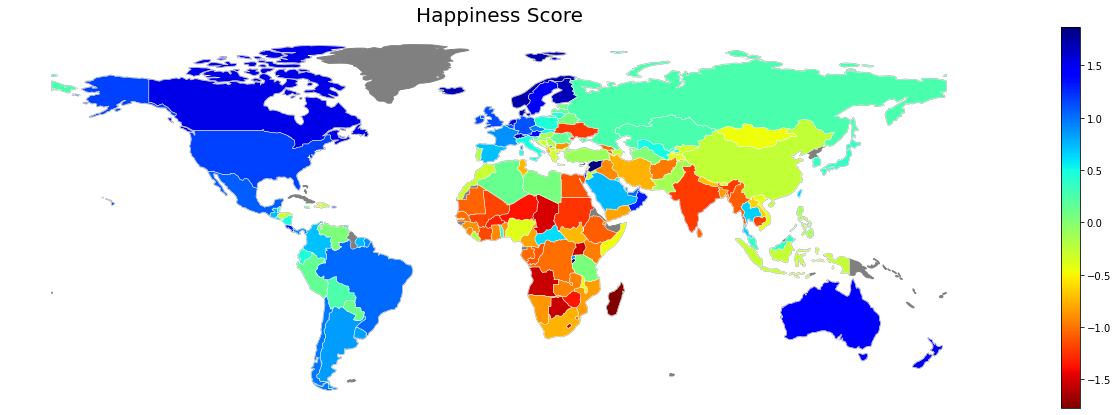

In [23]:
#Happines Score map
fig, ax = plt.subplots(figsize=(25,7))
base = world.plot(ax=ax,color='grey', edgecolor='grey')
gdf.plot(ax=base,column='Happiness Score',legend=True,cmap='jet_r',edgecolor='white',linewidth=0.5)
ax.set_title("Happiness Score",fontsize=20)
ax.set_axis_off()

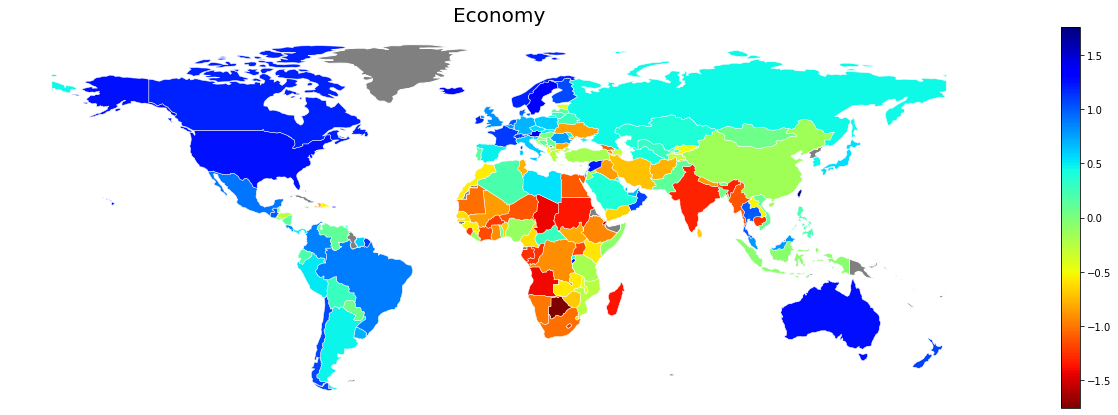

In [24]:
#Economy map
fig, ax = plt.subplots(figsize=(25,7))
base = world.plot(ax=ax,color='grey', edgecolor='white')
gdf.plot(ax=base,column='Economy',legend=True,cmap='jet_r',edgecolor='white',linewidth=0.5 )
ax.set_title("Economy",fontsize=20)
ax.set_axis_off()

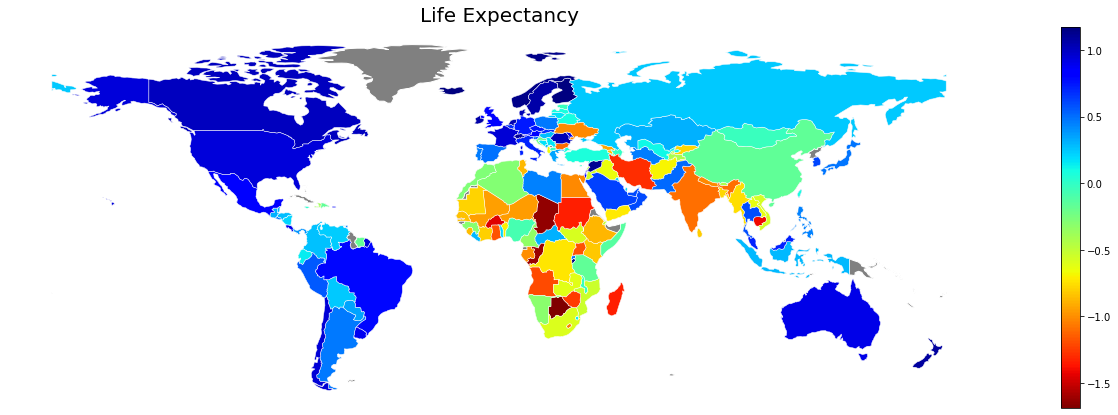

In [25]:
#Life Expectancy map
fig, ax = plt.subplots(figsize=(25,7))
base = world.plot(ax=ax,color='grey', edgecolor='white')
gdf.plot(ax=base,column='Life Expectancy',legend=True,cmap='jet_r' ,edgecolor='white',linewidth=0.5)
ax.set_title("Life Expectancy",fontsize=20)
ax.set_axis_off()

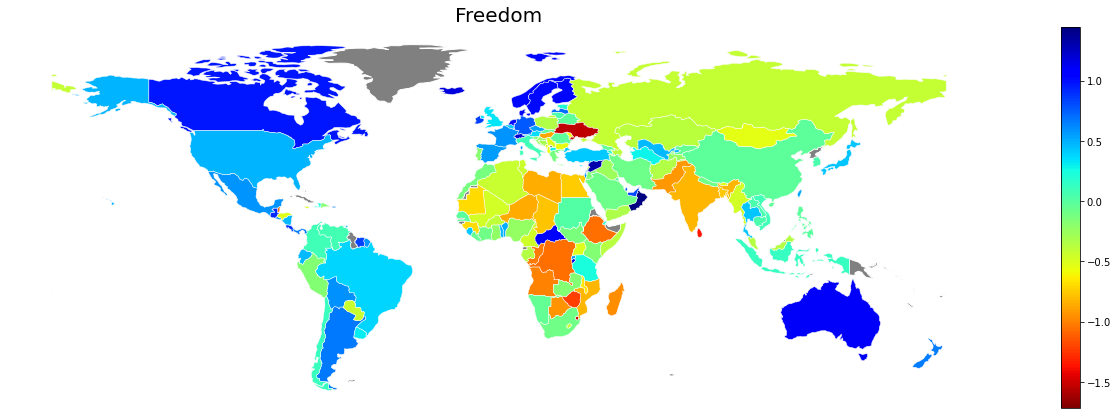

In [26]:
#Freedom map
fig, ax = plt.subplots(figsize=(25,7))
base = world.plot(ax=ax,color='grey', edgecolor='white')
gdf.plot(ax=base,column='Freedom',legend=True,cmap='jet_r',edgecolor='white',linewidth=0.5 )
ax.set_title("Freedom",fontsize=20)
ax.set_axis_off()

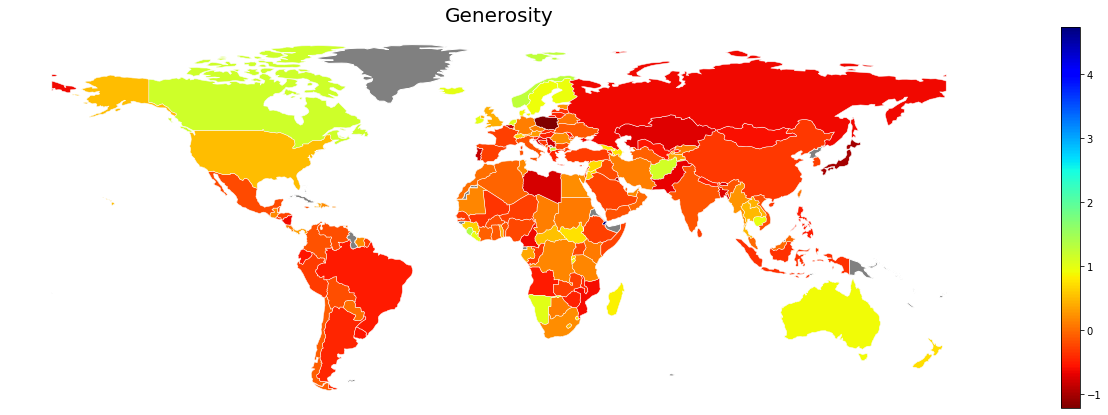

In [27]:
#Generosity map
fig, ax = plt.subplots(figsize=(25,7))
base = world.plot(ax=ax,color='grey', edgecolor='white')
gdf.plot(ax=base,column='Generosity',legend=True,cmap='jet_r',edgecolor='white',linewidth=0.5 )
ax.set_title("Generosity",fontsize=20)
ax.set_axis_off()

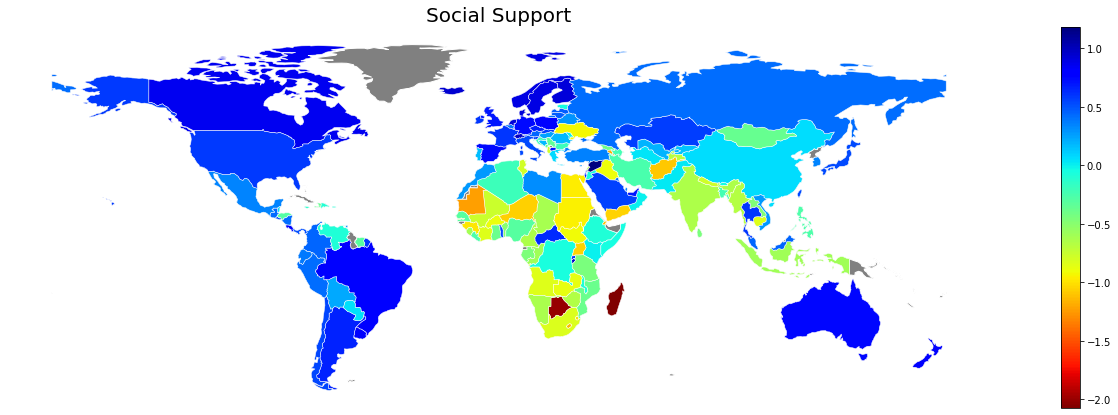

In [28]:
#Social Support map
fig, ax = plt.subplots(figsize=(25,7))
base = world.plot(ax=ax,color='grey', edgecolor='white')
gdf.plot(ax=base,column='Social Support',legend=True,cmap='jet_r',edgecolor='white',linewidth=0.5 )
ax.set_title("Social Support",fontsize=20)
ax.set_axis_off()

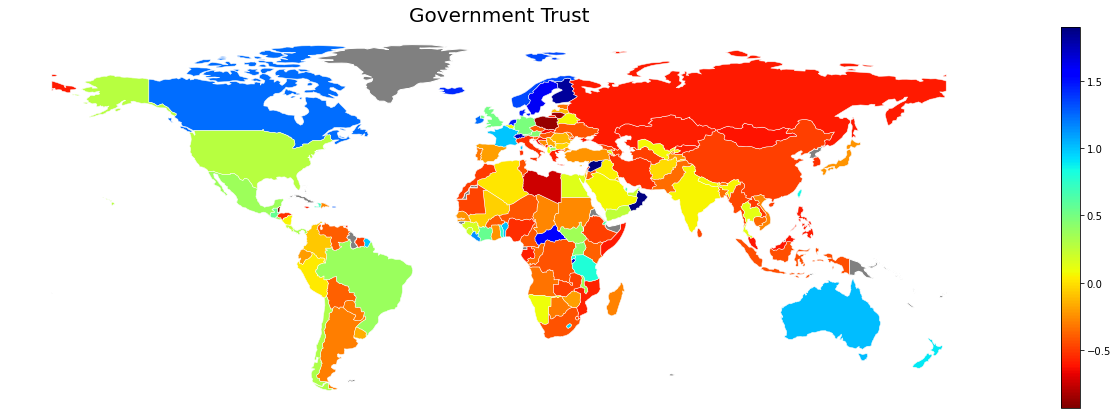

In [29]:
#Government Trust map
fig, ax = plt.subplots(figsize=(25,7))
base = world.plot(ax=ax,color='grey', edgecolor='white')
gdf.plot(ax=base,column='Government Trust',legend=True,cmap='jet_r',edgecolor='white',linewidth=0.5 )
ax.set_title("Government Trust",fontsize=20)
ax.set_axis_off()

# Exploratory analysis


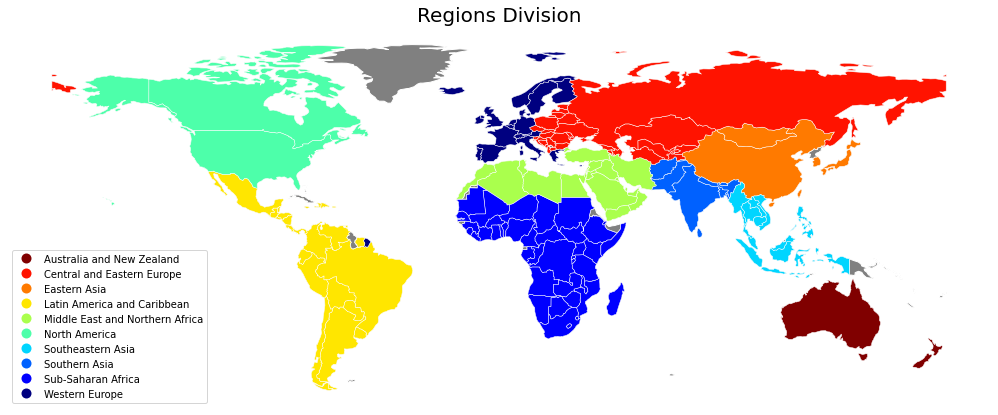

In [30]:
#Region Divisions
fig, ax = plt.subplots(figsize=(25,7))
base = world.plot(ax=ax,color='grey', edgecolor='white')
gdf.plot(ax=base,column='Region',cmap='jet_r',edgecolor='white',linewidth=0.5,legend=True, legend_kwds={'loc': 'lower left'} )
ax.set_title("Regions Division",fontsize=20)
ax.set_axis_off()

In [31]:
#Country % ranking for each feature and year
for yr in list(df_scale['Year'].unique()):
    for col in df_scale.columns[0:7]:
        df_scale.loc[df_scale['Year'] == yr,str('Ranking '+col)]=  round(df_scale.loc[df_scale['Year'] == yr, col].rank(method='dense',ascending=False)/df_scale.loc[df_scale['Year'] == yr, col].count()*100,2)

,Happiness Score,Economy,Social Support,Life Expectancy,Freedom,Government Trust,Generosity,Ranking Happiness Score,Ranking Economy,Ranking Social Support,Ranking Life Expectancy,Ranking Freedom,Ranking Government Trust,Ranking Generosity
count,7.700000e+02,7.700000e+02,7.700000e+02,7.700000e+02,7.700000e+02,7.700000e+02,7.700000e+02,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000
mean,8.708762e-16,-3.630573e-16,-4.296707e-17,-1.516824e-16,3.125927e-16,2.083470e-17,2.649396e-16,49.518195,49.231753,48.584948,46.344208,47.175779,45.609714,46.066013
std,1.000650e+00,1.000650e+00,1.000650e+00,1.000650e+00,1.000650e+00,1.000650e+00,1.000650e+00,28.410231,28.181999,28.126779,27.577705,27.390817,26.164073,26.799836
min,-2.371367e+00,-2.252889e+00,-3.259628e+00,-2.458677e+00,-2.688580e+00,-1.181994e+00,-1.792030e+00,0.650000,0.650000,0.650000,0.650000,0.650000,0.650000,0.650000
25%,-7.759839e-01,-7.632016e-01,-6.331939e-01,-6.882364e-01,-6.605971e-01,-6.712036e-01,-7.072151e-01,24.920000,25.320000,24.067500,22.730000,23.417500,24.030000,23.380000
50%,-5.117075e-02,1.608338e-01,1.383129e-01,1.454295e-01,1.270437e-01,-3.306488e-01,-1.350724e-01,49.510000,48.700000,48.380000,45.130000,46.600000,44.810000,44.955000
75%,7.208315e-01,7.834381e-01,7.614231e-01,7.900207e-01,7.813069e-01,2.923841e-01,5.023232e-01,74.030000,73.380000,72.730000,68.980000,69.867500,64.290000,67.265000
max,2.105849e+00,2.895314e+00,1.707066e+00,2.132240e+00,2.037526e+00,4.039289e+00,5.082501e+00,99.350000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


Text(0.5, 1.0, 'Distribuição das variáveis')

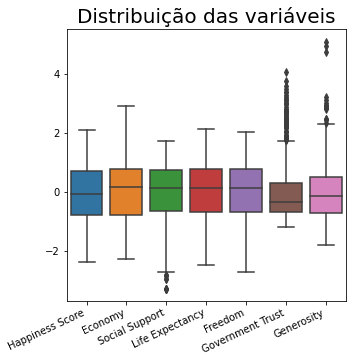

In [32]:
#DataFrame description
display(df_scale.describe())
#Boxplot
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(data=df_scale.iloc[:,0:7])
plt.xticks(rotation=25,ha='right');
ax.set_title("Distribuição das variáveis",fontsize=20)

It is noticed the presence of some outliers, mainly in the Government Trust and Generosity categories in their upper ranges, meaning that only some countries have indicators above the majority in these indicators.

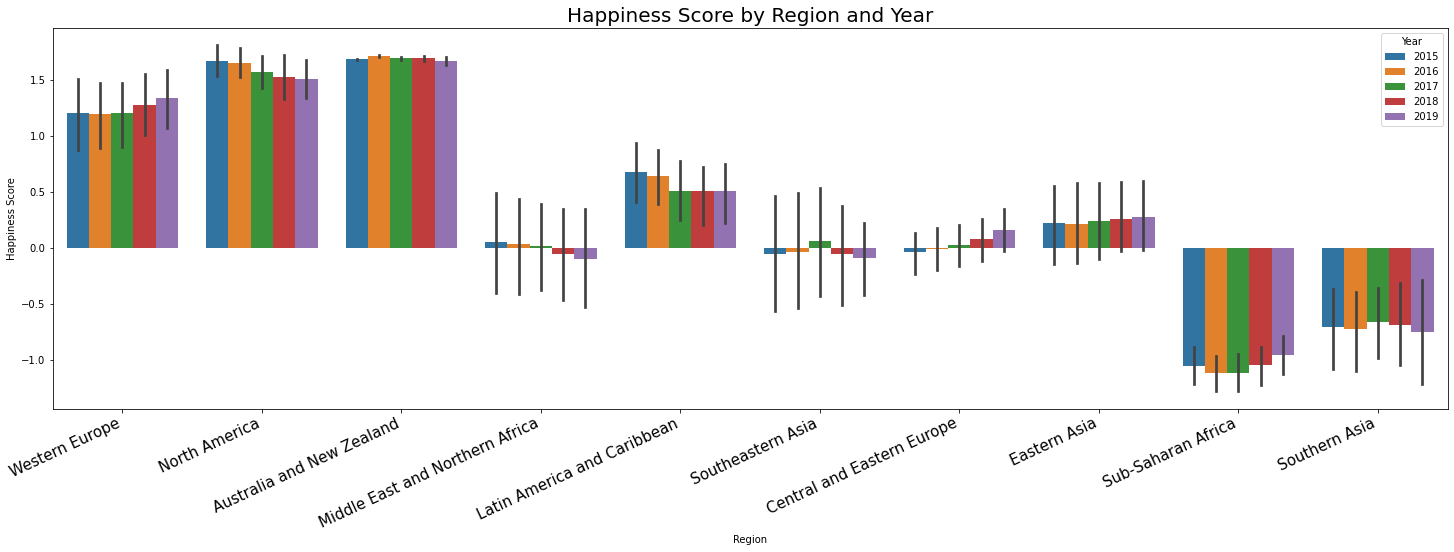

In [33]:
# Visualization of the level of Happiness by year and by region

fig, ax = plt.subplots(figsize=(25,7))
sns.barplot(x=df_scale['Region'],y=df_scale['Happiness Score'],hue=df_scale['Year'])
ax.set_title("Happiness Score by Region and Year",fontsize=20)
plt.xticks(rotation=25,ha='right',fontsize=15);

The Australia and New Zealand region averages the highest happiness value, while the Sub-Saharan Africa region the lowest. The region of North America and Latin America and the Caribbean showed an average regression of the level of happiness in these years.

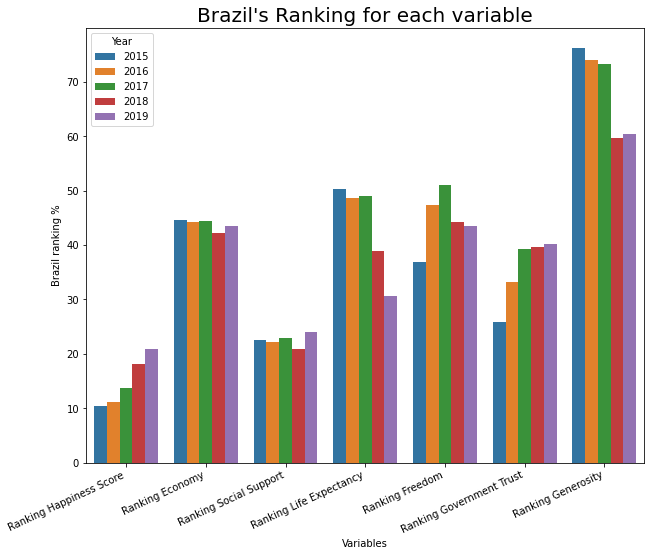

In [34]:
# Brazil

brazil=df_scale.loc[df_scale['Country']=='Brazil','Year':'Ranking Generosity']
fig, ax = plt.subplots(figsize=(10,8))
brdf = pd.melt(brazil.iloc[:,[0,3,4,5,6,7,8,9]],id_vars='Year')
sns.barplot(data=brdf,x='variable',y='value',hue='Year')
plt.ylabel('Brazil ranking %')
plt.xlabel('Variables')
ax.set_title("Brazil's Ranking for each variable",fontsize=20)
plt.xticks(rotation=25,ha='right');



Between the years 2015 and 2019 Brazil has consecutively lost positions in the ranking of Happiness, as well as in Government Trust. Economically and in Social Support indicators, it remained in similar positions. There was an improvement in the life expectancy and generosity indicator.

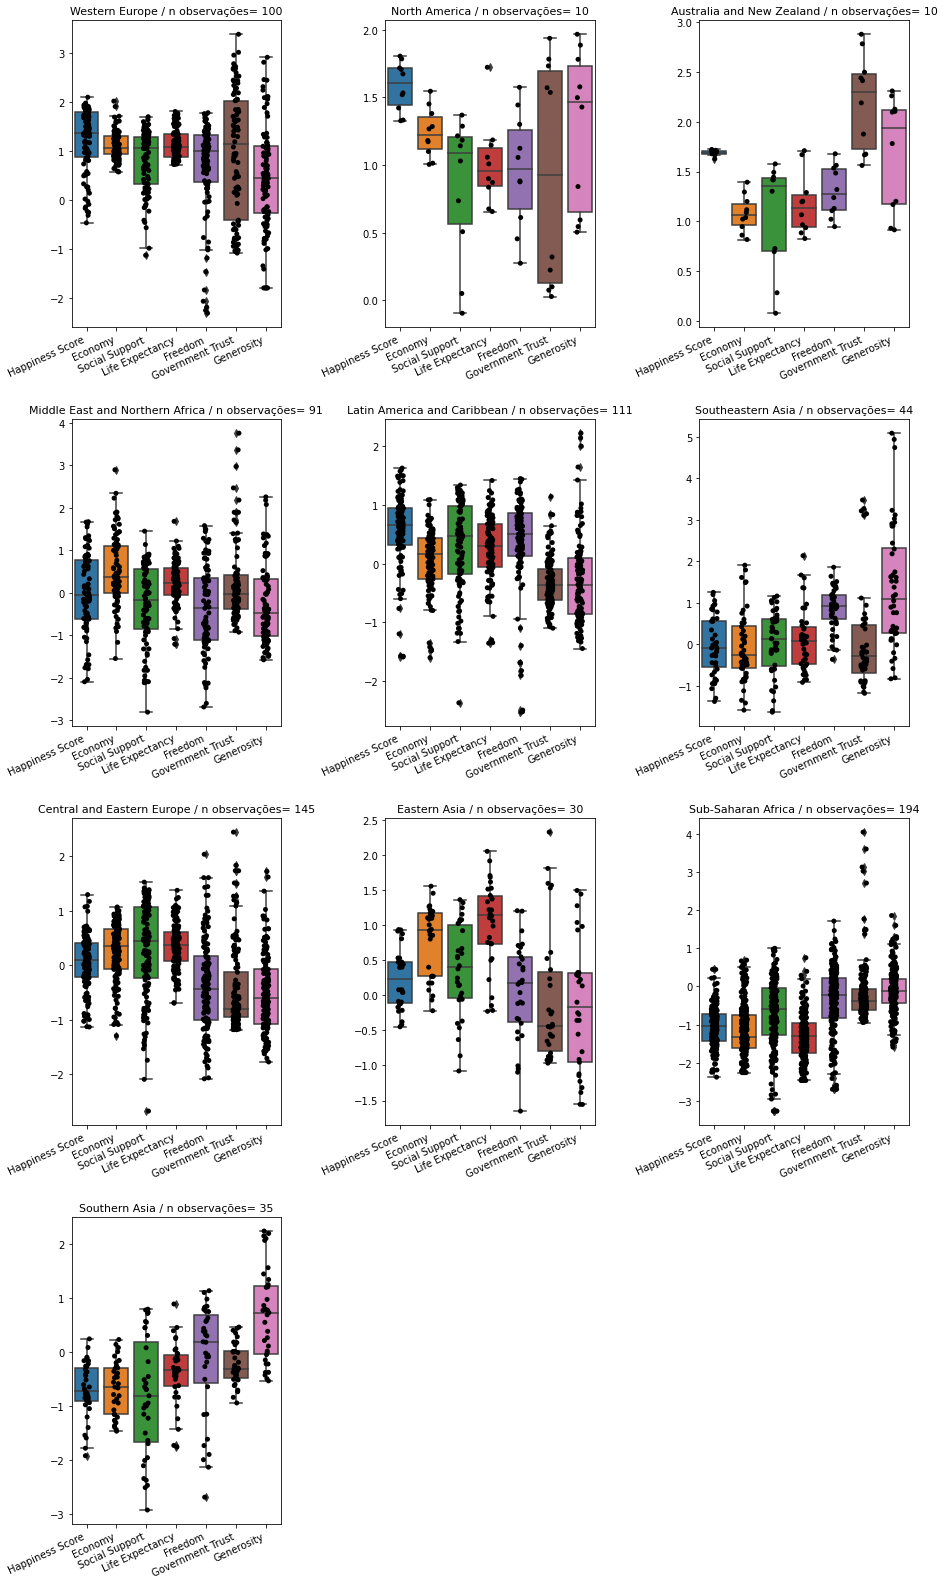

In [35]:
#Verifying data distribution
fig = plt.figure(figsize=(15,35))
i=0
for reg in list(df['Region'].unique()):  
    ax=plt.subplot(5,3,i+1)
    
    sns.boxplot(data=df_scale[df_scale['Region']==reg].iloc[:,0:7])
    
    ax = sns.stripplot(data=df_scale[df_scale['Region']==reg].iloc[:,0:7],
                   color="black", edgecolor="gray")
    
    t=str(reg+' / n observações= '+str(df_scale.groupby('Region').count().loc[reg][0]))
    ax.set_title(t,fontsize=11)
    plt.xticks(rotation=25,ha='right');
    i+=1
plt.subplots_adjust(hspace=0.3,wspace=0.5)

<Figure size 360x360 with 0 Axes>

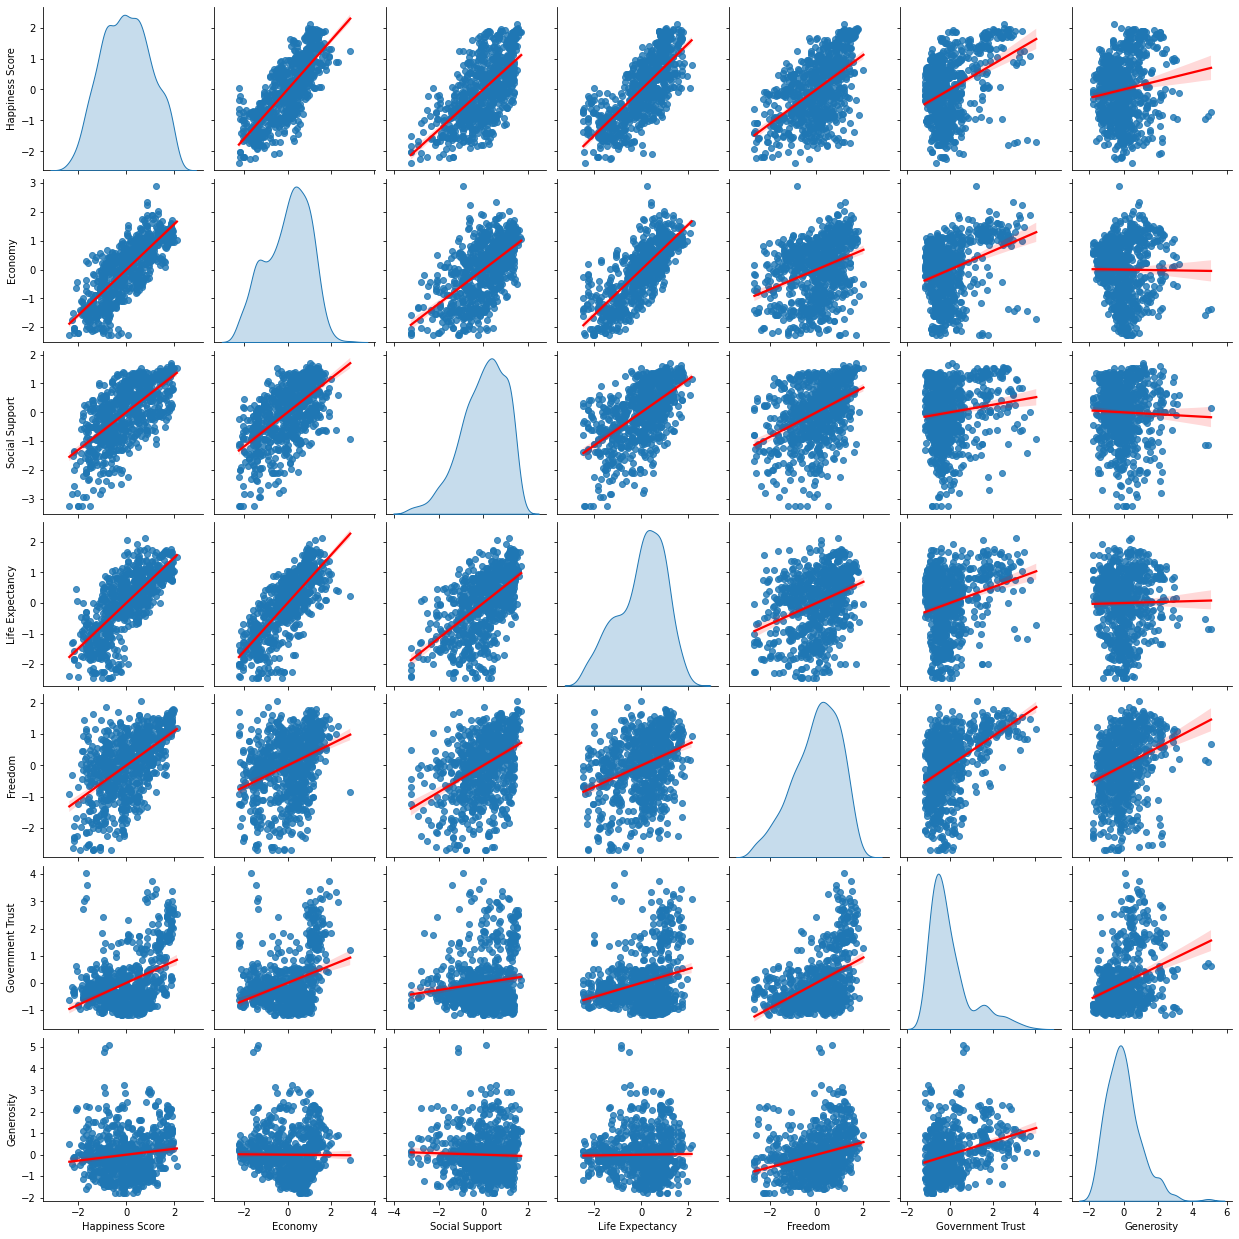

In [36]:
#Pair plot
plt.figure(figsize=(5,5));
sns.pairplot(df_scale.iloc[:,0:7],diag_kind='kde',kind='reg',plot_kws={'line_kws':{'color':'red'}});

There is a clear linearity trend between happiness and economic indicators, social support and life expectancy,also between life expectancy and economy
There is an imbalance in the distribution of confidence in the government, with a tail to the right, that is, few countries have high values in this indicator.
Countries with a high degree of confidence in the Government tend, with the exception of the Generosity indicator, to present very high social indicators.

<AxesSubplot:>

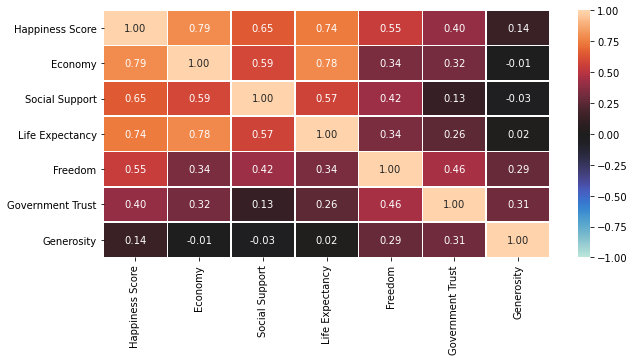

In [37]:
#Correlation map
fig= plt.figure(figsize=(10,10))

ax1=plt.subplot(2,1,1)

sns.heatmap(df_scale.iloc[:,0:7].corr(), annot=True, fmt=".2f", linewidths=.5,vmin=-1, vmax=1, center= 0,ax=ax1)  

Analyzing the correlation numerically, it is observed that the level of Happiness is more correlated with the Economy and Life Expectancy than with Generosity, Freedom and Government Trust. Note: correlation does not imply in causality.


# Regression

In this section, two models of multiple linear regrassion will be implemented, Ordinary Least Squares from the stats model package and the stochastic gradient descent from skleanr package.


In [38]:
#Scaled data X y split
SEED=np.random.seed(401)
Xs=df_scale.iloc[:,1:7]

ys=df_scale.iloc[:,0]

##Para estrafificar dados  continuos
# #Regra de Sturger qquantidade de bins
# nbins=np.around(1+10/3*np.log10(ys_pre.count())).astype(int)
# #divisao dos bins
# bins=pd.cut(ys_pre,nbins,labels=np.linspace(1,nbins,nbins))
# bins.name='bins'
# ys=pd.concat([ys_pre,bins],axis=1)

#Train Test Split
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys,test_size=0.30,random_state=SEED)
#Adding constant for stats model package
Xsc_train = sm.add_constant(Xs_train)
Xsc_test = sm.add_constant(Xs_test)

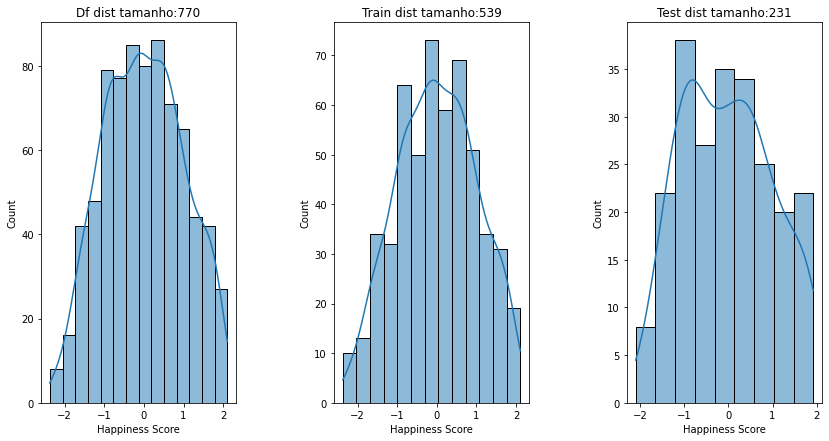

In [39]:
#Data train test distribuition
fig= plt.figure(figsize=(14,7))
plt.subplots_adjust(hspace=0.5,wspace=0.5)    

ax1=plt.subplot(1,3,1)
ax1.set_title('Df dist tamanho:'+str(len(ys)))
sns.histplot(ys,ax=ax1,kde=True);

ax2=plt.subplot(1,3,2)
ax2.set_title('Train dist tamanho:'+str(len(ys_train)))
sns.histplot(ys_train,ax=ax2,kde=True);

ax3=plt.subplot(1,3,3)
ax3.set_title('Test dist tamanho:'+str(len(ys_test)))
sns.histplot(ys_test,ax=ax3,kde=True);

In [40]:
#Verifying Multicollinearity of the data 
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF=pd.Series([variance_inflation_factor(Xs.values,i) for i in range(Xs.shape[1])], index=Xs.columns)
print(VIF)

Economy             2.972890
Social Support      1.840004
Life Expectancy     2.756752
Freedom             1.614245
Government Trust    1.452837
Generosity          1.180679
dtype: float64


If the value is higher than 5 then the explanatory variable is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Happiness Score   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     279.8
Date:                Tue, 27 Oct 2020   Prob (F-statistic):          5.79e-161
Time:                        19:43:58   Log-Likelihood:                -377.97
No. Observations:                 539   AIC:                             769.9
Df Residuals:                     532   BIC:                             800.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0087      0.021      0.411      0.681      -0.033       0.050
Economy              0.4112      0.037     11.134      0.000       0.339       0.484
Social Support       0.1725      0.029      6.011      0.000       0.116       0.229
Life Expectancy      0.2335      0.035      6.617      0.000       0.164       0.303
Freedom              0.2148      0.027      7.966      0.000       0.162       0.268
Government Trust     0.0703      0.026      2.749      0.006       0.020       0.120
Generosity           0.0644      0.024      2.675      0.008       0.017       0.112
==============================================================================
Omnibus:                        7.900   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                8.043
Skew:                          -0.246   Prob(JB):                       0.0179
Kurtosis:                       3.340   Cond. No.                         3.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

OLS
Type Name                                 
Eval R2 Treino                    0.759354
     R2 Teste                     0.777057
     MSE Teste                    0.228530
     p-value Heterocedasticidade  0.157834
     Durbin Watson                1.906143
Coef const                        0.008717
     Economy                      0.411214
     Social Support               0.172523
     Life Expectancy              0.233540
     Freedom                      0.214775
     Government Trust             0.070259
     Generosity                   0.064390

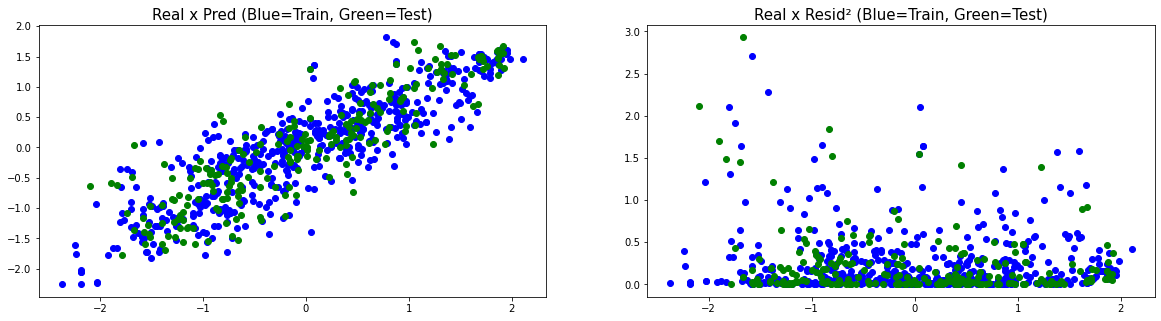

In [41]:
#Ordinary Least Squares model
mOLS_scale=sm.OLS(ys_train,Xsc_train)
lr_scale=mOLS_scale.fit()
display(lr_scale.summary())

#Residuals
predict_train=lr_scale.predict(Xsc_train)
residual_train=lr_scale.resid
predict_test=lr_scale.predict(Xsc_test)
residual_test=ys_test-predict_test
residual_test_OLS=residual_test

#R2 square
OLS_r2_train=sk.metrics.r2_score(ys_train,predict_train)
OLS_r2_test=sk.metrics.r2_score(ys_test,predict_test)

#Mean Square error
OLS_MSE=mean_squared_error(ys_test,predict_test)

#test durbin_watson statistic for n=550 and k=6 dl=1.780 dU=1.824 H0= null hypothesis of zero autocorrelation o 
#if dw>dU do not reject
dw=durbin_watson(residual_train)

#H0=all observations have the same error variance, the errors are homocedastic
bp_scale=diag.het_breuschpagan(residual_test, Xsc_test)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

#Dataframe with coeficient and parameters
OLS_coef=lr_scale.params.tolist()
label_coef=[['Coef'],['const','Economy','Social Support','Life Expectancy','Freedom','Government Trust','Generosity']]
idx_c=pd.MultiIndex.from_product(label_coef,names=['Type','Name'])
OLS_c=pd.Series(OLS_coef,name='OLS',index=idx_c)

OLS_eval=[OLS_r2_train, OLS_r2_test,OLS_MSE,bp_scale[1],dw]
label_ev=[['Eval'],['R2 Treino', 'R2 Teste', 'MSE Teste', 'p-value Heterocedasticidade','Durbin Watson']]
idx_e=pd.MultiIndex.from_product(label_ev,names=['Type','Name'])
OLS_e=pd.Series(OLS_eval,name='OLS',index=idx_e)

OLS_df=pd.DataFrame(pd.concat([OLS_e,OLS_c],axis=0))
display(OLS_df)

#Plot of the predicted value and squared error against real value
fig= plt.figure(figsize=(20,5))

ax1=plt.subplot(1,2,1)
ax1.set_title('Real x Pred (Blue=Train, Green=Test)',fontsize=15)

plt.scatter(x=ys_train,y=predict_train,c='b');
plt.scatter(x=ys_test,y=predict_test,c='g');


ax2=plt.subplot(1,2,2)
ax2.set_title('Real x Resid² (Blue=Train, Green=Test)',fontsize=15)
plt.scatter(x=ys_train,y=residual_train**2,c='b');
plt.scatter(x=ys_test,y=residual_test**2,c='g');


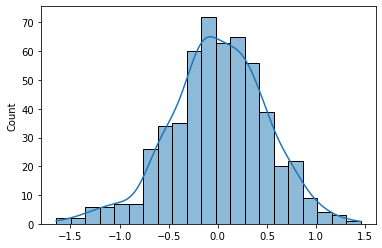

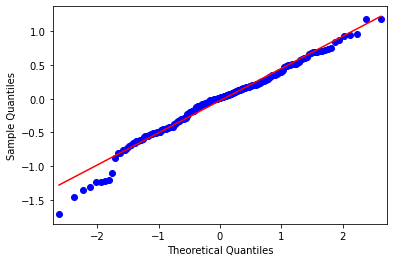

In [42]:
#distribuição  dos  residuos
sns.histplot(residual_train,kde=True)
sm.qqplot(residual_test,line='s')
plt.show()

SGD
Type Name                                 
Eval R2 Treino                    0.759053
     R2 Teste                     0.776892
     MSE Teste                    0.228698
     p-value Heterocedasticidade  0.155426
     Durbin Watson                1.893765
Coef const                        0.009300
     Economy                      0.386474
     Social Support               0.181042
     Life Expectancy              0.253871
     Freedom                      0.212102
     Government Trust             0.074922
     Generosity                   0.056210

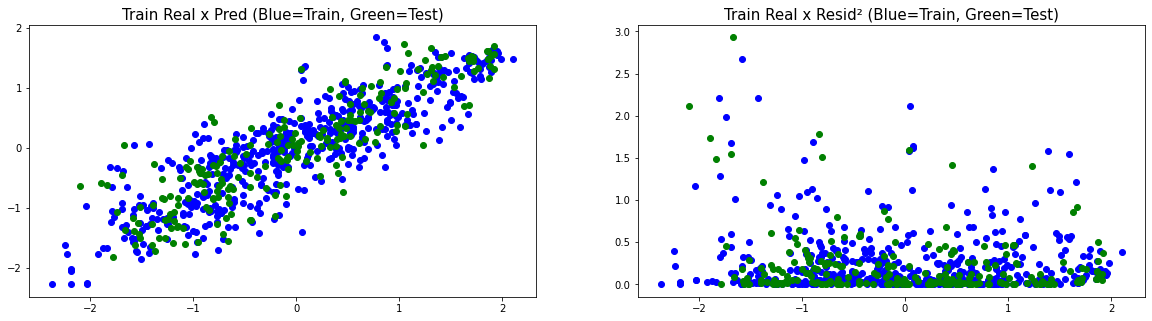

In [43]:
#Stochastic gradient descent
mSGD=SGDRegressor(loss='squared_loss')
mSGD.fit(Xs_train,ys_train)

#Model residual and prediciton
predict_train=mSGD.predict(Xs_train)
residual_train=ys_train-predict_train

predict_test=mSGD.predict(Xs_test)
residual_test=ys_test-predict_test
residual_test_SGD=residual_test

#R2 square
SGD_r2_train=sk.metrics.r2_score(ys_train,predict_train)
SGD_r2_test=sk.metrics.r2_score(ys_test,predict_test)

#Mean Square error
mSGD_MSE=mean_squared_error(ys_test,predict_test)


#Verificar Heterostacidade p>0.05 para regeitar hHeterostacidade
bp_scale=diag.het_breuschpagan(residual_test,Xsc_test)

#durbin_watson Test,for n=550 and k=6  => dl=1.780 dU=1.824; H0=null hypothesis of zero if dw>dU do not reject
dw=durbin_watson(residual_train)

#Dataframe with coeficient and parameters
mSGD_coef= mSGD.coef_
mSGD_intercept=mSGD.intercept_
mSGD_param=np.concatenate([mSGD_intercept,mSGD_coef])
label_coef=[['Coef'],['const','Economy','Social Support','Life Expectancy','Freedom','Government Trust','Generosity']]
idx_c=pd.MultiIndex.from_product(label_coef,names=['Type','Name'])
SGD_c=pd.Series(mSGD_param,name='SGD',index=idx_c)

SGD_eval=[SGD_r2_train, SGD_r2_test, mSGD_MSE, bp_scale[1],dw]
label_ev=[['Eval'],['R2 Treino', 'R2 Teste', 'MSE Teste', 'p-value Heterocedasticidade', 'Durbin Watson']]
idx_e=pd.MultiIndex.from_product(label_ev,names=['Type','Name'])
SGD_e=pd.Series(SGD_eval,name='SGD',index=idx_e)

SGD_df=pd.DataFrame(pd.concat([SGD_e,SGD_c],axis=0))
display(SGD_df)

#Plot of the predicted value and squared error against real value
fig= plt.figure(figsize=(20,5)) 

ax1=plt.subplot(1,2,1)
ax1.set_title('Train Real x Pred (Blue=Train, Green=Test)',fontsize=15)

plt.scatter(x=ys_train,y=predict_train,c='b');
plt.scatter(x=ys_test,y=predict_test,c='g');


ax2=plt.subplot(1,2,2)
ax2.set_title('Train Real x Resid² (Blue=Train, Green=Test)',fontsize=15)
plt.scatter(x=ys_train,y=residual_train**2,c='b');
plt.scatter(x=ys_test,y=residual_test**2,c='g');


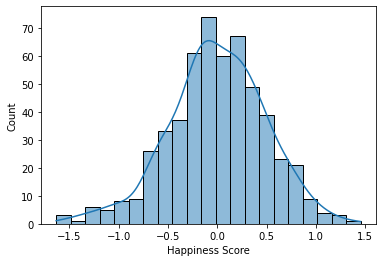

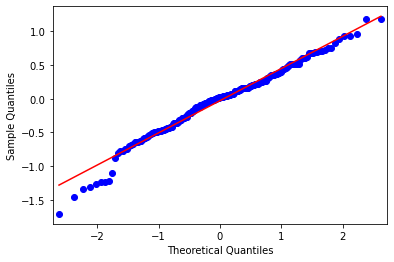

In [44]:
sns.histplot(residual_train,kde=True)
sm.qqplot(residual_test,line='s')
plt.show()

By the values of R2, it is posssible to say that both the OLS and SGD models can explain 75.9 and 77.7% of the variations of the input data, for the training and test data respectively 

The p-value for all model explanatory variables showed a value less than .05, indicating that they are highly significant for the model

The Durbin Watson test was larger than the upper limit, so the null autocorrelation hypothesis cannot be rejected.

Observing the residual2 dispersion grahp, we can infer that visually the model tends to present more significant errors for countries that have a lower level of happiness.

As in the Breusch-Pagan test the p-value is greater than .15 on OLS and greater than 0.13 on SGD, so there is little statistical significance against the acceptance of the null hypothesis of homeostacy.

The histogram shows that both the models tends to overestimate the happiness value, given the larger tail in the negative values

visually by q-q graph the residues approach a normal

Thus the model meets the Four Assumptions of Linear Regression:

Linear relationship: There exists a linear relationship between the independent variable, x, and the dependent variable, y.

Independence: The residuals are independent. In particular, there is no correlation between consecutive residuals in time series data.

Homoscedasticity: The residuals have constant variance at every level of x.

Normality: The residuals of the model are normally distributed.


ValueError: x and y must be the same size

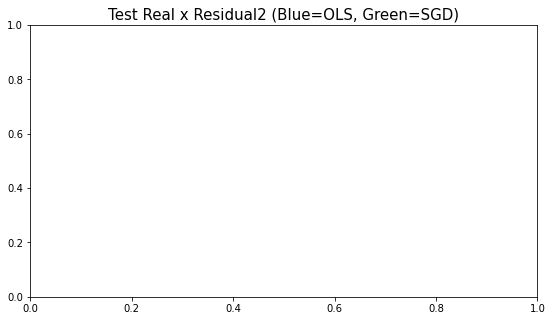

In [45]:
fig= plt.figure(figsize=(20,5)) 

ax=plt.subplot(1,2,1)
ax.set_title('Test Real x Residual2 (Blue=OLS, Green=SGD)',fontsize=15)

plt.scatter(x=ys_train,y=residual_test_SGD**2,c='g');
plt.scatter(x=ys_test,y=residual_test_OLS**2,c='b');

In [ ]:
comp=pd.concat([OLS_df,SGD_df],axis=1)
display(comp)
comp.loc['Eval'].plot(kind='bar')
plt.xticks(rotation=25,ha='right');
comp.loc['Coef'].plot(kind='bar')
plt.xticks(rotation=25,ha='right');

Comparing the performance of  both models they are very similar.
Since the modols where feeded by scalled data its possible to  infer that the variable's coeficient is comperable to the wheight, the importance, the model gives to each explanatory variable. Both models tend to give a higher wheight for the Economy folowed by Life Expectancy indicator, and the least wheight for Generosity and Government Trust. This align with the correlation analysis done previously.

In [ ]:
#Extracting those with residual above 2 sig.
resd=residual_train
sig2sup=residual_train.std()*2+residual_train.mean()
sig2inf=-residual_train.std()*2+residual_train.mean()

bottom=resd[resd<sig2inf]
top=resd[resd>sig2sup]
idx=(top+bottom).index

df_tb=df_scale.loc[idx,:]
df_tb['Residual']=pd.concat([top,bottom])
df_tb['tb']='Sobre Estimados'
for ind in top.index:
    df_tb.loc[ind,'tb']='Sub Estimados'
    
df_tb.sort_values('tb',inplace=True)       


In [ ]:
#Verifying data distribution for each year
fig = plt.figure(figsize=(20,60))
i=0
n=df_tb.count()[0]
for ind in list(df_tb.index):  
    ax=plt.subplot(int(np.ceil(n/3)),3,i+1)
    ax.set_ylim([0,100])
    
    df_tb.loc[ind].iloc[10:17].plot(kind='bar', colormap='Blues_r')
    
    t=str(df_tb.loc[ind].iloc[9]+' '+df_tb.loc[ind].iloc[18]+' Residual: '+
          str(round(df_tb.loc[ind].iloc[17],2))+' Year: '+df_tb.loc[ind].iloc[7])
    ax.set_title(t,fontsize=11)
    plt.xticks(rotation=45,ha='right');
    i+=1
plt.subplots_adjust(hspace=1,wspace=0.5)

Analisando os dados que apresentam mais de dois sigmas de erro percebse que parte dos paises que tiveram seu valor de felicidade sobreestimados, ou sejaa, que foram preditados como sendo mais felizes do que deveria apresentam ao menos uma das seguintes caracteristicas::
Pais possui um ou dois de seus indicadores bem abixo dos outros exemplos, rwanda 2018 e 2017 2016 2019  e Tanzania 2017 com indicadores de liberdade e confiança do governo bem elevados
Paises que contam com fatores nao avalisados pela pesquisa, ex HongKong que apesar de apresentar indicadores elevados possui nivel de felicidade relativamente baixo, muito  provavel devido  as questoes politicas da região.
Para os paises  subestimatdos ou seja  em  que  foram preditos com  um valor maior de felicidade do que naa realidade, muito  provavel que haja  um  outro fator nao  explicados  pelos  dados  uma   vez que  neles  os  valores  medios dos indicadores e strao  sempre  bem a cima  da felicidade  real.

Analyzing the datas that have more than two sigmas of error, it can be seen that part of the countries that had their happiness value overestimated, that is, that were predicted to be happier than they should have, present at least one of the following characteristics:
-Country has one or two of its indicators way above the other, Rwanda 2017 2016 2018 and 2019 and Tanzania 2017 presents very high indicators of freedom and government confidence, represented graphically by the low position on the ranking.
-Countries that have factors not evaluated by the survey, e.g. HongKong which despite presenting high indicators has a relatively low level of Happiness, very likely due to the political issues of the Region.

For countries that are underestimated, that is, where they were predicted with a higher happiness value than in reality, it is very likely that there is another factor not explained by the data, since the average values of the indicators are always well above the true happiness. Another hypothesis is that the weight given to social indicators may be different from that established by the models, the Economy of these countries may not be the most important factor in Happiness